# 2D Recurrent Neural Network Position Model

### Load Data

In [35]:
NUM_ITERS = 23500

NUM_CLASSES = 4
NUM_HIDDEN = 30
ROLLOUT = 10
LEARNING_RATE = 0.005
REGULARIZER = 0.001

In [36]:
%store -r rnn_shots

df = rnn_shots['df']
sideways = df.T

X, Y = np.array(sideways.ix[['x', 'y']]).astype(float), np.array(sideways.ix['label']).astype(int)

### Data

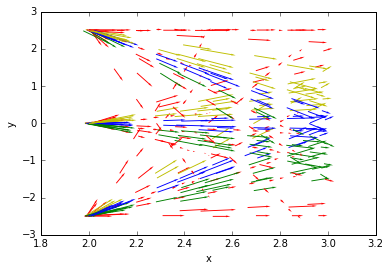

In [37]:
colormap = np.array(['r', 'g', 'b', 'y'])
labels = df['label']
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

### Train

In [38]:
from rnn.model import RecurrentNeuralNetwork

rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, rollout=ROLLOUT, learning_rate=LEARNING_RATE, regularizer=REGULARIZER, gradient_checking=False, inspect=True)

def states(iters):
    for i in range(iters):
        if not i % 1000:
            print('{}%...'.format((i/NUM_ITERS)*100, end=''))
                  
        rnn.learn()
        yield rnn.info
        
states = list(states(NUM_ITERS))

0.0%...
4.25531914893617%...
8.51063829787234%...
12.76595744680851%...
17.02127659574468%...
21.27659574468085%...
25.53191489361702%...
29.78723404255319%...
34.04255319148936%...
38.297872340425535%...
42.5531914893617%...
46.808510638297875%...
51.06382978723404%...
55.319148936170215%...
59.57446808510638%...
63.829787234042556%...
68.08510638297872%...
72.3404255319149%...
76.59574468085107%...
80.85106382978722%...
85.1063829787234%...
89.36170212765957%...
93.61702127659575%...
97.87234042553192%...


### Plot Losses

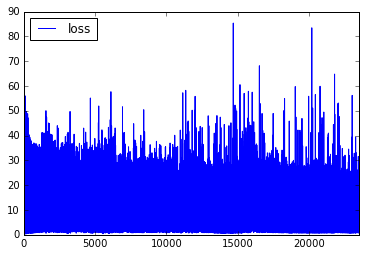

In [39]:
def loss_averages():
    for state in states:
        yield state.loss
        
losses = list(loss_averages())

pd.DataFrame(losses, columns=['loss']).plot()

### Visualize

/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


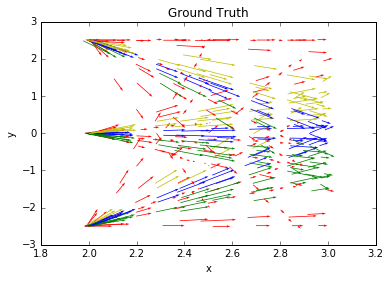

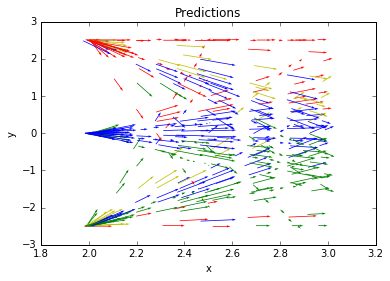

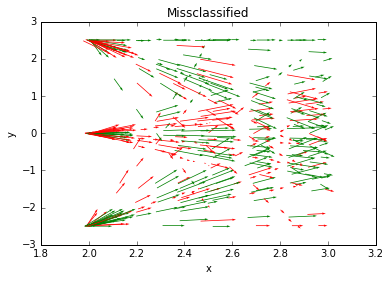

In [40]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, Whh=s.Whh, bhh=s.bhh, Wxh=s.Wxh, bxh=s.bxh, Ws=s.Ws, bs=s.bs)

    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Predictions
    scores, predictions = rnn.predict(X)
    df['predictions'] = predictions
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

### Raw Accuracy

In [41]:
df['correct'].sum() / len(df)

0.52127659574468088

### Shot Accuracy

In [42]:
df['predict_shot'] = (df.predictions == 1) | (df.predictions == 2) | (df.predictions == 3)
df['label_shot'] = (df.label == 1) | (df.label == 2) | (df.label == 3)
df['correct_shot'] = df.predict_shot == df.label_shot

df['correct_shot'].sum().astype(float) / len(df)

0.63191489361702124

### Pickle Model

In [43]:
import pickle

with open('/home/ebanner/nao/trunk/core/python/behaviors/position-rnn.py', 'wb') as f:
    pickle.dump(rnn, f)